## Single Layer RNN Pytorch from Scratch
In this notebook we want to perform

In [6]:
# libraries
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from tqdm.auto import tqdm

import os
import unicodedata
import string
import random

In [7]:
# read dataset
PATH = '../data/'
ALL_LETTERS = string.ascii_letters + '.,;'


def to_ascii(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)\
            if unicodedata.category(c) != 'Mn' \
                and c in ALL_LETTERS
    )

names = []
labels = []
all_labels = []

for f in os.listdir(PATH):
    label = f[:-4]
    all_labels.append(label)

    with open(PATH + f, encoding='utf-8') as r:
        lines = r.read().strip().split('\n')

        # names.extend([to_ascii(l) for l in lines])
        names.extend(lines)
        labels.extend([label for _ in range(len(lines))])

assert len(names) == len(labels)

# shuffle dataset
index = list(range(len(names)))
random.shuffle(index)
names = [names[i] for i in index]
labels = [labels[i] for i in index]

In [8]:
# build vocab
chars = tuple(set(''.join(names)))
int2char = dict(enumerate(chars, 1))    # start vocab index from 1, bcs we will use 0 for padding
int2char[0] = '<PAD>'   # add padding to vocab
char2int = {v: k for k, v in int2char.items()}

# encode words
names_enc = [[char2int[ch] for ch in name] for name in names]

# encode labels
labels_enc = np.array([all_labels.index(x) for x in labels])

In [9]:
# pad features
seq_length = max([len(x) for x in names_enc])

def pad_features(names, seq_length):    
    features = np.zeros((len(names), seq_length), dtype=int)

    for i, row in enumerate(names):
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

features = pad_features(names_enc, seq_length)

assert len(features) == len(names_enc)
assert len(features[0]) == seq_length

features[:2, :]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 76, 44,
        66, 63, 55, 43],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 40, 44,
        39, 43, 87, 63]])

In [ ]:
# train test split
train_size = .8     # we will use 80% of data as train set
val_size = .5       # we will use 50% of test set as validation set

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels_enc[:split_id], labels_enc[split_id:]

test_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:test_id], remain_x[test_id:]
val_y, test_y = remain_y[:test_id], remain_y[test_id:]

print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

In [11]:
# generate batches
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 64

# dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
validloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [12]:
# check train data
diter = iter(trainloader)
x, y = diter.next()

print('Sample input size: ', x.size()) # batch_size, seq_length
print('Sample input: \n', x)
print()
print('Sample label size: ', y.size()) # batch_size
print('Sample label: \n', y)

Sample input size:  torch.Size([64, 20])
Sample input: 
 tensor([[ 0,  0,  0,  ..., 74,  4, 87],
        [ 0,  0,  0,  ..., 43, 44, 63],
        [ 0,  0,  0,  ..., 71, 87, 63],
        ...,
        [ 0,  0,  0,  ..., 56, 55, 17],
        [ 0,  0,  0,  ..., 43, 87, 63],
        [ 0,  0,  0,  ...,  9,  4, 44]])

Sample label size:  torch.Size([64])
Sample label: 
 tensor([12,  6,  6, 10,  9,  4,  9,  6,  6,  3,  9,  9,  2,  9,  6, 12, 15, 14,
         6,  6,  9,  9,  9,  6, 12, 12,  2,  2,  6,  3,  6,  3,  6,  6, 11,  3,
         6,  6,  4,  7,  6,  6,  0,  9,  6,  9,  6,  9,  6,  3,  6,  6,  6,  6,
        12,  2,  6,  6,  6,  6, 10,  2,  6,  6])


In [13]:
# network architecture from scratch
class NameRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, embedding_size=32):
        super(NameRNN, self).__init__()

        self.hidden_size = hidden_size

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # here we define linear layer for each hidden, and output calculation
        # we use linear layer bcs it perform W * x + b formula.        
        self.hidden = nn.Linear(embedding_size + hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

        # activation function
        # we use softmax bcs we want to predict one of several labels/classes
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, h_prev):
        # map input into vector
        x = self.embedding(x)
        # print(f'Embedding size: {x.shape}')
        # print(f'H_prev size: {h_prev.shape}')

        # compute current hidden state by merging
        # current input and previous hidden state
        h = self.hidden(torch.cat([h_prev, x], dim=-1))
        # print(f'Hidden size: {h.shape}')
        h = torch.tanh(h)

        # add validation
        assert h.size == h_prev.size()

        # compute output by inserting current hidden state
        out = self.output(h)
        out = self.softmax(out)

        return h, out
        

    def init_hidden(self, batch_size):
        # initialize hidden state with zeros
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

In [14]:
# network architecture using PyTorch function
class NameRNN(nn.Module):
    def __init__(self, vocab_size=len(char2int), hidden_size=64, output_size=len(all_labels), embedding_size=16):
        super(NameRNN, self).__init__()

        self.hidden_size = hidden_size

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # RNN layer preserved by PyTorch library
        # this layer handles RNN Cell loops
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)

        # Linear layer for output
        self.output = nn.Linear(hidden_size, output_size)

        # softmax activation function
        # we use softmax bcs we want to predict one of several labels/classes
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # its optional to init hidden state by ourselves
        # bcs PyTorch will handle it if we don't provide it

        # map input to vector
        x = self.embedding(x)

        # compute current hidden state
        o, h = self.rnn(x)    
        
        # get last sequence output
        o = o[:, -1, :]
        
        # compute output
        out = self.output(o)
        # out = self.softmax(out)

        return out

In [15]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [16]:
# model hyperparameters
vocab_size = len(char2int)
output_size = len(all_labels)
embedding_dim = 16
hidden_dim = 128

model = NameRNN(vocab_size, hidden_dim, output_size, embedding_dim)
print(model)

NameRNN(
  (embedding): Embedding(88, 16)
  (rnn): RNN(16, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=18, bias=True)
  (softmax): Softmax(dim=-1)
)


In [17]:
lr = 0.0001
criterion = nn.CrossEntropyLoss()
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 500
print_every = 100
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

In [ ]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training...', leave=True)

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0
    
    # tqdm training progressbar
    # trainloop = tqdm(trainloader, leave=True)
    # trainloop.set_description(f'Epoch {e+1}/{epochs} | Training')

    # for feature, target in trainloop:
    for feature, target in trainloader:
        target = target.type(torch.LongTensor)
        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass        
        out = model(feature)

        # acc
        predicted = torch.argmax(out, dim=1)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        # train_acc.append(acc.item())
        train_acc += acc.item()

        # loss
        loss = criterion(out, target)
        # train_loss.append(loss.item())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()
        
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ###################
    # validation mode #
    ###################

    model.eval()

    val_loss = 0
    val_acc = 0

    # tqdm validation progressbar
    # valloop = tqdm(validloader, leave=True)
    # valloop.set_description(f'Epoch {e+1}/{epochs} | Validation')

    # turn off gradient
    with torch.no_grad():
        # for feature, target in valloop:
        for feature, target in validloader:
            target = target.type(torch.LongTensor)
            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.argmax(out, dim=1)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            # val_acc.append(acc.item())
            val_acc += acc.item()

            # loss
            loss = criterion(out, target)
            # val_loss.append(loss.item())
            val_loss += loss.item()

        history['val_loss'].append(val_loss / len(validloader))
        history['val_acc'].append(val_acc / len(validloader))

    # reset model mode
    model.train()

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss/len(trainloader):.4f} | Val Loss: {val_loss/len(validloader):.4f}, Acc: {val_acc/len(validloader):.4f}')
        epochloop.update()
        # print(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss/len(trainloader):.4f} | Val Loss: {val_loss/len(validloader):.4f}, Acc: {val_acc/len(validloader):.4f}', flush=True)
        
    epochloop.set_postfix_str(f'Val Loss: {val_loss/len(validloader):.3f}')
    # TODO: Add save model and early stop mechanism

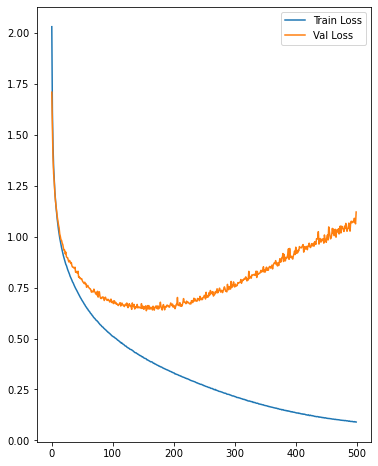

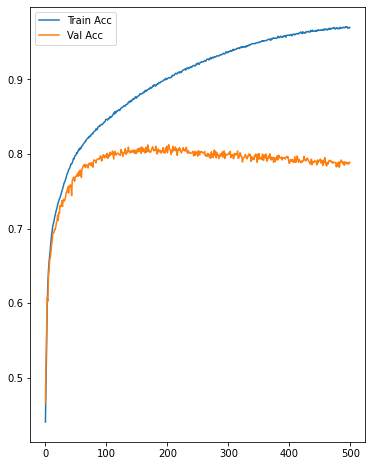

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 8))
plt.plot(range(epochs), history['train_loss'], label='Train Loss')
plt.plot(range(epochs), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6, 8))
plt.plot(range(epochs), history['train_acc'], label='Train Acc')
plt.plot(range(epochs), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

In [18]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

testloop = tqdm(testloader, leave=True, desc='Inference...')
with torch.no_grad():
    for feature, target in testloop:
        target = target.type(torch.LongTensor)
        # move to device
        feature, target = feature.to(device), target.to(device)
        
        # forward pass
        out = model(feature)

        # acc
        predicted = torch.argmax(out, dim=1)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))        
        test_acc += acc.item()

        # loss
        loss = criterion(out, target)        
        test_loss += loss.item()

    print(f'Accuracy: {test_acc/len(testloader)}, Loss: {test_loss/len(testloader)}')

Inference...: 100%|██████████| 32/32 [00:00<00:00, 275.44it/s]

Accuracy: 0.775227865204215, Loss: 1.0514864269644022
